# Possion equation

$$ - u_{xx} = f $$
$$ - (v, u_{xx}) = (v,f) $$
$$ (v_{x}, u_{x}) = (v,f) $$
$$ u_{h} = \sum_{i=1}^{N.o.f}\xi_{i}\phi_{i}(x) $$
$$ \sum_{i=1}^{N.o.f}(\dot{\phi_{j}}, \dot{\phi_{i}}) = \sum_{i=1}^{N.o.f}(\phi_{j}, f) $$

$$ A\xi = F $$
$$ A_{ij} = \int \dot{\phi_{j}}(x)\dot{\phi_{i}}(x) dx$$
$$ F_{ij} = \int \phi_{j}(x)f dx$$


In [1]:
import numpy as np
from scipy.sparse import dok_matrix
from scipy.integrate import solve_bvp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

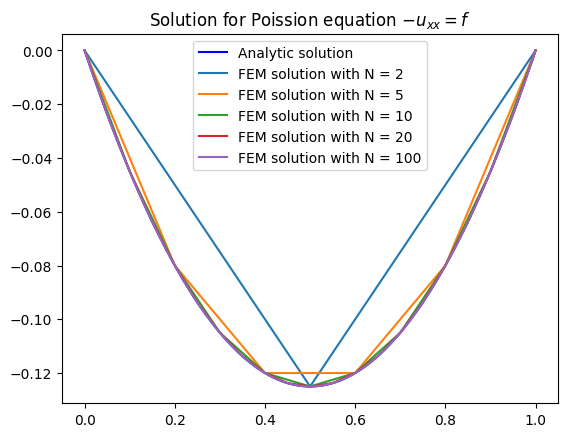

In [2]:
a = 0
b = L = 1
def f(x):
    return -1

basis = {"eval": {"phi0": lambda x: x, "phi1": lambda x: 1-x}, 
        "nabla": {"phi0_nabla": lambda x: 1, "phi1_nabla": lambda x: -1}}
quad = [(0, 1/6), (0.5, 4/6), (1, 1/6)]
x_real = np.linspace(a, b, 100000) 
#Analytic solution
u = 0.5*(x_real**2 - L * x_real)

plt.figure()
plt.title("Solution for Poission equation $-u_{xx} = f$")
plt.plot(x_real, u, color = "blue", label = "Analytic solution")

DOF = len(basis["eval"])/2

for N in [2, 5, 10, 20, 100]:
    N = int(DOF * N)
    h = (b-a)/N
    x = np.linspace(a, b, N+1)
    #Assemble stiffnes matrix
    A = np.zeros([N + 1, N + 1])
    F = np.zeros([N + 1, 1])

    for k in range(N):
        for base in basis.keys():   
            for j, phi_j in enumerate(basis[base].values()):
                for iter, weight in quad:
                    if base == "eval":
                        F[k + j] += h * weight * phi_j(iter) * f(x)
                    if base == "nabla":
                        for i, phi_i in enumerate(basis[base].values()):    
                            A[k + j , k + i] += 1/h * weight * phi_j(iter) * phi_i(iter)
    #print(A)
    A[0, :] = A[-1, :] = 0
    A[0, 0] = A[-1, -1] = 1
    F[0] = F[-1] = 0
    XI = np.linalg.solve(A, F)
    plt.plot(x, XI.flatten(), label = f'FEM solution with N = {N}')



plt.legend()
plt.show()

# With Cubic Hermit Polynomilas

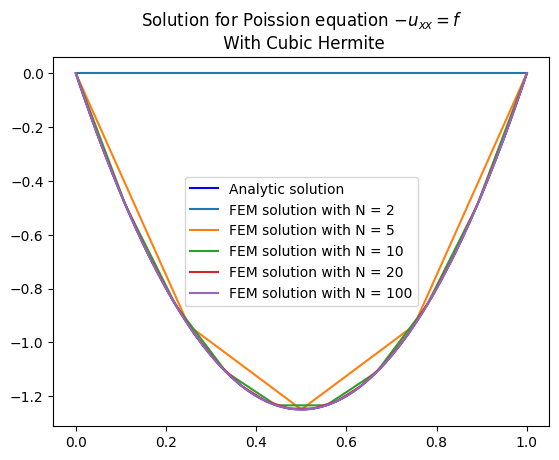

In [3]:
a = 0
b = L = 1
def f(x):
    return -10

basis = {"eval": 
        {"H1": lambda x: (2*x**3 - 3*x**2 + 1), 
         "H2": lambda x: (x**3 - 2*x**2 + x), 
         "H3": lambda x: (-2*x**3 + 3*x**2), 
         "H4": lambda x: (x**3 - x**2)
         },
         "nabla": 
         {"H1_prime": lambda x: (6*x**2 - 6*x), 
          "H2_prime": lambda x: (3*x**2 - 4*x + 1),
          "H3_prime": lambda x: (6*x - 6*x**2),
          "H4_prime": lambda x: (3*x**2 - 2*x)
         } 
}

dim = 2*len(basis)
N_iter = 100000
local_stiffnes = np.zeros((dim, dim))
x_real = np.linspace(a, b, N_iter) 
#Analytic solution
u = -f(x)*0.5*(x_real**2 - L * x_real)

plt.figure()
plt.title("Solution for Poission equation $-u_{xx} = f$ \n With Cubic Hermite")
plt.plot(x_real, u, color = "blue", label = "Analytic solution")

for N in [2, 5, 10, 20, 100]:
    nel = N-1
    ndof = N*2

    h = 1.0/nel
    x = np.linspace(a, b, N)
    #Assemble stiffnes matrix
    
    A = np.zeros((ndof, ndof))
    F = np.zeros(ndof)
    steps = 1/N_iter
    iter = np.linspace(0, 1, N_iter + 1)
    
    for k in range((nel + 1)//2):
        k = 4*k
        for base in basis.keys():   
            for j, Hj in enumerate(basis[base].values()):
                if base == "eval":
                    fx = Hj(iter) * f(iter)
                    F[k + j] = 2*h * (steps/3)*(fx[0] + 4*np.sum(fx[1:-1:2]) + 2*np.sum(fx[2:-2:2]) +fx[-1])
                if base == "nabla":
                        for i, Hi in enumerate(basis[base].values()):    
                            fx = Hj(iter)*Hi(iter)
                            local_stiffnes[j , i] = (steps/3)*(fx[0] + 4*np.sum(fx[1:-1:2]) + 2*np.sum(fx[2:-2:2]) +fx[-1])

    # Assembly loop
    for k in range(nel):

        kl, ku = 2*k, 2*k + 4
        A[kl:ku,kl:ku] += (1.0/h)*local_stiffnes

        idr = ndof - 2
        A[0,:] = A[idr,:] = 0
        A[0,0] = A[idr,idr] = 1.0
        F[0] = F[idr] = 0

    XI = np.linalg.solve(A, F)
    plt.plot(x, XI[0::2], label = f'FEM solution with N = {N}')



plt.legend()
plt.show()